In [213]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from joblib import Parallel, delayed
from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import time
import biosppy.signals.ecg as ecg
import neurokit2 as nk
import pyhrv
import hrv
import heartpy
import numpy as np
import pandas as pd
import os

ROOT_PATH = "/home/jupyter/Task 3/"



In [113]:
# Create a function that runs the GridSearchCV and outputs the mean score, the std score and saves the output
def run_model_optimization(X, y, pipeline, param_grid, scoring, logs_path="", backup_save=False, random_search=False, n_iter=1000, stratified=True):
    """
    Runs the GridSearchCV and returns the best model
    has options to save the output logs, and do backup saves, ...
    """
    tic = time.time()
    estimator = None
    if random_search:
        estimator = RandomizedSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring=scoring, verbose=2, pre_dispatch="n_jobs", n_iter=n_iter).fit(X,y)
    else:
        estimator = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring=scoring, verbose=2, pre_dispatch="n_jobs").fit(X, y)
    model = estimator.best_estimator_
    toc = time.time()
    print(toc-tic)

    if logs_path != "":
        logs = estimator.cv_results_
        df = pd.DataFrame.from_dict(logs)
        df.to_csv(ROOT_PATH + "logs_testing.csv", index=False)
    
    if backup_save:
        %store estimator
    
    params = estimator.best_params_
    if stratified:
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
        scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1, scoring=scoring)
    else:
        scores = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring=scoring)

    scores = scores.flatten()
    print("Mean score: ", scores.mean())
    print("Best params: ", params)
    print("Score deviation: ", scores.std())

    return model





In [114]:
# Load the data
X_train = pd.read_csv(ROOT_PATH + 'X_train.csv').drop("id", axis=1)
y_train = pd.read_csv(ROOT_PATH + 'y_train.csv').drop("id", axis=1)["y"]
assert len(X_train) == len(y_train)
# X_test = pd.read_csv(ROOT_PATH + 'X_test.csv').drop("id", axis=1)
# data_train = X_train.join(y_train)
print(len(y_train))

5117


In [4]:
# Data stats quickly
n_samples = X_train.shape[0]
n_features = X_train.shape[1]

print(len(y_train[y_train == 0]))
print(len(y_train[y_train == 1]))
print(len(y_train[y_train == 2]))
print(len(y_train[y_train == 3]))

3030
443
1474
170


In [5]:
# Data cleaning  - removing the newline character from the data
# Remove the newline character from raw data -- no need pandas dealt automatically with it
filteredColumns = X_train.dtypes[(X_train.dtypes != np.int64) & (X_train.dtypes != np.float64)]
assert len(filteredColumns) == 0

{dtype('int64'), dtype('float64')}


In [24]:
import pywt
import scipy 
import scipy.mstats
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

def bandpower(x, fs, fmin, fmax):
    f, Pxx = scipy.signal.periodogram(x, fs=fs)
    ind_min = scipy.argmax(f > fmin) - 1
    ind_max = scipy.argmax(f > fmax) - 1
    return scipy.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max])

def extract_signal_features(signal):
    
    # power, frequency band power, Shannon entropy, SNR
    
    data = signal.to_numpy()
    # ['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'] --> possible wavelet families
    coefs = pywt.wavedec(data, "db4")
    from scipy import stats 
    stats.signaltonoise(array1, axis = 0, ddof = 0))
    
    
    

SyntaxError: invalid syntax (<ipython-input-24-bb59914fd879>, line 24)

In [253]:
# Invert signal if needed
def check_if_signal_inverted(signal):
    org_signal = signal
    try:
        flipped_signal = (-1) * signal

        df1, info_a = nk.ecg_process(signal, sampling_rate=300)
        rpeaks1 = info_a["ECG_R_Peaks"]
        df2, info_a = nk.ecg_process(flipped_signal, sampling_rate=300)
        rpeaks2 = info_a["ECG_R_Peaks"]

        if df1["ECG_Clean"].to_numpy()[rpeaks1].mean() > 0:
            signal = org_signal
        else:
            signal = (-1) * org_signal # will have negative values !?
    except Exception as e:
        print("Couldn't check if signal is inverted: ", e)
        signal = org_signal
    return signal

In [223]:
from scipy.stats import mstats
def using_mstats(s):
    return mstats.winsorize(s, limits=[0.15, 0.15])

def extract_morphological_features(signal):
    try:
        df, info= nk.ecg_process(signal, sampling_rate=300)
        df["time"] = df.index / 300    
        df = df[(df.ECG_R_Peaks == 1) |(df.ECG_P_Peaks == 1) |(df.ECG_Q_Peaks == 1) |(df.ECG_S_Peaks == 1) |(df.ECG_T_Peaks == 1) |(df.ECG_P_Onsets == 1) |(df.ECG_T_Offsets== 1)]

        # Stats on the peaks
        num_P_vs_R =  df["ECG_P_Peaks"].sum()/df["ECG_R_Peaks"].sum()
        num_Q_vs_R =  df["ECG_Q_Peaks"].sum()/df["ECG_R_Peaks"].sum()
        num_S_vs_R =  df["ECG_S_Peaks"].sum()/df["ECG_R_Peaks"].sum()
        num_T_vs_R =  df["ECG_T_Peaks"].sum()/df["ECG_R_Peaks"].sum()

        # Calcualte all needed time and voltage values
        df["P_onset_time"] = np.where(df["ECG_P_Onsets"] == 1, df["time"], np.nan)
        df["P_time"] = np.where(df["ECG_P_Onsets"] == 1, df["time"], np.nan)
        df["Q_time"] = np.where(df["ECG_Q_Peaks"] == 1, df["time"], np.nan)
        df["R_time"] = np.where(df["ECG_R_Peaks"] == 1, df["time"], np.nan)
        df["S_time"] = np.where(df["ECG_S_Peaks"] == 1, df["time"], np.nan)
        df["T_time"] = np.where(df["ECG_T_Peaks"] == 1, df["time"], np.nan)
        df["T_offset_time"] = np.where(df["ECG_T_Offsets"] == 1, df["time"], np.nan)
        df[["P_onset_time", "P_time", "Q_time", "R_time", "S_time", "T_time", "T_offset_time"]] = df[["P_onset_time", "P_time", "Q_time", "R_time", "S_time", "T_time", "T_offset_time"]].ffill(axis = 0) 

        # Calculate the different intervals
        df["RR_time"] = np.where(df["ECG_R_Peaks"] == 1, df["R_time"] - df["R_time"].shift(periods=1), np.nan)
        RR_time_mean = df["RR_time"].dropna().apply(using_mstats).mean()
        RR_time_std = df["RR_time"].dropna().apply(using_mstats).std()
        df["PQ_time"] = np.where(df["ECG_Q_Peaks"] == 1, df["Q_time"] - df["P_onset_time"], np.nan)
        df["QRS_time"] = np.where(df["ECG_S_Peaks"] == 1, df["S_time"] - df["Q_time"], np.nan)
        df["ST_time"] = np.where(df["ECG_T_Peaks"] == 1, df["T_time"] - df["S_time"], np.nan)
        df["QR_time"] = np.where(df["ECG_R_Peaks"] == 1, df["R_time"] - df["Q_time"], np.nan)
        df["RS_time"] = np.where(df["ECG_S_Peaks"] == 1, df["S_time"] - df["R_time"], np.nan)
        df["QT_time"] = np.where(df["ECG_T_Peaks"] == 1, df["T_time"] - df["Q_time"], np.nan)
        df["TP_time"] = np.where(df["ECG_P_Peaks"] == 1, df["P_time"] - df["T_time"], np.nan)

        # If value obviously wrong set it to null
        df["PQ_time"] = np.where(df["PQ_time"] > RR_time_mean, np.nan, df["PQ_time"])
        df["QRS_time"] = np.where(df["QRS_time"] > RR_time_mean, np.nan, df["QRS_time"])
        df["ST_time"] = np.where(df["ST_time"] > RR_time_mean, np.nan, df["ST_time"])
        df["QR_time"] = np.where(df["QR_time"] > RR_time_mean, np.nan, df["QR_time"])
        df["RS_time"] = np.where(df["RS_time"] > RR_time_mean, np.nan, df["RS_time"])
        df["QT_time"] = np.where(df["QT_time"] > RR_time_mean, np.nan, df["QT_time"])
        df["TP_time"] = np.where(df["TP_time"] > RR_time_mean, np.nan, df["TP_time"])

        # Get stats on the relative amplitude of the signals
        df["R_voltage"] = np.where(df["ECG_R_Peaks"] == 1, df["ECG_Clean"], np.nan)
        df["R_voltage"] = df["R_voltage"].ffill(axis=0)
        R_voltage_mean = df["R_voltage"].dropna().apply(using_mstats).mean()
        R_voltage_std = df["R_voltage"].dropna().apply(using_mstats).std()
        df["P_voltage"] = np.where(df["ECG_P_Peaks"] == 1, df["ECG_Clean"]/df["R_voltage"], np.nan)
        df["Q_voltage"] = np.where(df["ECG_Q_Peaks"] == 1, df["ECG_Clean"]/df["R_voltage"], np.nan)
        df["S_voltage"] = np.where(df["ECG_S_Peaks"] == 1, df["ECG_Clean"]/df["R_voltage"], np.nan)
        df["T_voltage"] = np.where(df["ECG_T_Peaks"] == 1, df["ECG_Clean"]/df["R_voltage"], np.nan)
        df["ST_voltage"] = np.where(df["ECG_T_Peaks"] == 1, (df["T_voltage"] - df["S_voltage"]), np.nan)
        df[["P_voltage", "Q_voltage", "S_voltage", "T_voltage"]] = df[["P_voltage", "Q_voltage", "S_voltage", "T_voltage"]].ffill(axis = 0) 

        # Slopes of QR, RS and ST intervals
        df["QR_slope"] = np.where(df["ECG_R_Peaks"] == 1, (df["R_voltage"] - df["Q_voltage"])/ (df["R_time"] - df["Q_time"]), np.nan)
        df["RS_slope"] = np.where(df["ECG_S_Peaks"] == 1, (df["S_voltage"] - df["R_voltage"])/ (df["S_time"] - df["R_time"]), np.nan)
        df["ST_slope"] = np.where(df["ECG_T_Peaks"] == 1, (df["T_voltage"] - df["S_voltage"])/ (df["T_time"] - df["S_time"]), np.nan)

        output_df = pd.DataFrame(dtype=np.float64)
        output_df["num_P_vs_R"] = [num_P_vs_R]
        output_df["num_Q_vs_R"] = num_Q_vs_R
        output_df["num_S_vs_R"] = num_S_vs_R
        output_df["num_t_vs_R"] = num_T_vs_R
        features = ["RR_time", "PQ_time", "QRS_time", "ST_time", "R_voltage", "P_voltage", "S_voltage", "T_voltage", "Q_voltage", 
                    "ST_voltage", "QT_time", "TP_time", "QT_time", "TP_time", "QR_slope", "RS_slope", "ST_slope",]
        for feature in features:
            output_df[feature+"_mean"] = df[feature].dropna().apply(using_mstats).mean()
            output_df[feature+"_std"] = df[feature].dropna().apply(using_mstats).std()
            output_df[feature+"_median"] = df[feature].dropna().apply(using_mstats).median()
    except Exception as e:
        print("Couldn't extract morphological features", e)
        columns = ['num_P_vs_R', 'num_Q_vs_R', 'num_S_vs_R', 'num_t_vs_R', 'RR_time_mean',
                   'RR_time_std', 'RR_time_median', 'PQ_time_mean', 'PQ_time_std',
                   'PQ_time_median', 'QRS_time_mean', 'QRS_time_std', 'QRS_time_median',
                   'ST_time_mean', 'ST_time_std', 'ST_time_median', 'R_voltage_mean',
                   'R_voltage_std', 'R_voltage_median', 'P_voltage_mean', 'P_voltage_std',
                   'P_voltage_median', 'S_voltage_mean', 'S_voltage_std',
                   'S_voltage_median', 'T_voltage_mean', 'T_voltage_std',
                   'T_voltage_median', 'Q_voltage_mean', 'Q_voltage_std',
                   'Q_voltage_median', 'ST_voltage_mean', 'ST_voltage_std',
                   'ST_voltage_median', 'QT_time_mean', 'QT_time_std', 'QT_time_median',
                   'TP_time_mean', 'TP_time_std', 'TP_time_median', 'QR_slope_mean',
                   'QR_slope_std', 'QR_slope_median', 'RS_slope_mean', 'RS_slope_std',
                   'RS_slope_median', 'ST_slope_mean', 'ST_slope_std', 'ST_slope_median']
        empty_data = np.empty((1,len(columns)))
        empty_data[:] = np.nan
        output_df = pd.DataFrame(data=empty_data, columns=columns)   
    return output_df

    
signal = X_train.iloc[0, :].dropna().to_numpy()
df = extract_morphological_features(signal)
print(df.columns)


Index(['num_P_vs_R', 'num_Q_vs_R', 'num_S_vs_R', 'num_t_vs_R', 'RR_time_mean',
       'RR_time_std', 'RR_time_median', 'PQ_time_mean', 'PQ_time_std',
       'PQ_time_median', 'QRS_time_mean', 'QRS_time_std', 'QRS_time_median',
       'ST_time_mean', 'ST_time_std', 'ST_time_median', 'R_voltage_mean',
       'R_voltage_std', 'R_voltage_median', 'P_voltage_mean', 'P_voltage_std',
       'P_voltage_median', 'S_voltage_mean', 'S_voltage_std',
       'S_voltage_median', 'T_voltage_mean', 'T_voltage_std',
       'T_voltage_median', 'Q_voltage_mean', 'Q_voltage_std',
       'Q_voltage_median', 'ST_voltage_mean', 'ST_voltage_std',
       'ST_voltage_median', 'QT_time_mean', 'QT_time_std', 'QT_time_median',
       'TP_time_mean', 'TP_time_std', 'TP_time_median', 'QR_slope_mean',
       'QR_slope_std', 'QR_slope_median', 'RS_slope_mean', 'RS_slope_std',
       'RS_slope_median', 'ST_slope_mean', 'ST_slope_std', 'ST_slope_median'],
      dtype='object')


In [237]:
# Extract HRV features if needed
def extract_hrv_features(signal):
    try:
        df, info = nk.ecg_process(signal, sampling_rate=300)
        analyze_df = nk.ecg_analyze(df, sampling_rate=300)
    except Exception as e:
        print("Couldnt' extract HRV features", e)
        columns = ['ECG_Rate_Mean', 'HRV_RMSSD', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_SDSD',
                   'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN',
                   'HRV_IQRNN', 'HRV_pNN50', 'HRV_pNN20', 'HRV_TINN', 'HRV_HTI', 'HRV_ULF',
                   'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_LFHF', 'HRV_LFn',
                   'HRV_HFn', 'HRV_LnHF', 'HRV_SD1', 'HRV_SD2', 'HRV_SD1SD2', 'HRV_S',
                   'HRV_CSI', 'HRV_CVI', 'HRV_CSI_Modified', 'HRV_PIP', 'HRV_IALS',
                   'HRV_PSS', 'HRV_PAS', 'HRV_GI', 'HRV_SI', 'HRV_AI', 'HRV_PI', 'HRV_C1d',
                   'HRV_C1a', 'HRV_SD1d', 'HRV_SD1a', 'HRV_C2d', 'HRV_C2a', 'HRV_SD2d',
                   'HRV_SD2a', 'HRV_Cd', 'HRV_Ca', 'HRV_SDNNd', 'HRV_SDNNa', 'HRV_ApEn',
                   'HRV_SampEn']
        empty_data = np.empty((1,len(columns)))
        empty_data[:] = np.nan
        analyze_df = pd.DataFrame(data=empty_data, columns=columns)
    return analyze_df

signal = X_train.iloc[10, :].dropna().to_numpy()
df = extract_hrv_features(signal)


In [248]:
# Extract wavelet features
def extract_wavelet_features(signal):
    try:
        # Segment the timeseries by heartbeat
        df, info = nk.ecg_process(signal, sampling_rate=300)
        epochs = nk.ecg_segment(df["ECG_Clean"].to_numpy(), rpeaks=info["ECG_R_Peaks"], sampling_rate=300, show=False)

        # Combine the segments back into one pandas DF
        df_out = None
        segmented_len = 0
        for epoch, df in epochs.items():
            segmented_len += len(df)
            if df_out is None:
                df_out = df
                df_out["epoch"] = int(epoch)
                df_out["index"] = np.arange(len(df_out))
            else:
                df["epoch"] = np.ones(len(df)) * int(epoch)
                df["index"] = np.arange(len(df))
                df_out = pd.concat([df, df_out], axis=0, ignore_index=False)

        # Calculate the representative heartbeat of this signal --> don't we lose a lot of information here?
        df_out["median_val"] = df_out[["Signal", "index"]].groupby("index").transform(np.median)
        groups = df_out.groupby("epoch") 
        max_correlation = 0
        max_epoch = None
        for name, group in groups: 
            correlation = group[["Signal", "median_val"]].corr(method="spearman").loc["Signal", "median_val"]
            if correlation > max_correlation:
                max_correlation = correlation
                max_epoch = name

        # Keep only the "most representative" heartbeat
        df_out = df_out[df_out.epoch == max_epoch]

        # Resample the signal to ensure the same number of features across samples
        import scipy
        resampled_signal = scipy.signal.resample(df_out["median_val"].to_numpy(), 256, t=None, axis=0, window=None, domain='time')

        coeffs = pywt.wavedec(resampled_signal, wavelet='db4', level=3)
        coeffs_filtered = pywt.threshold(coeffs[0], max(10, np.max(coeffs[0]/20.)), mode='soft', substitute=0)  # set to 0 components with small values
        coeffs = pd.DataFrame(data=coeffs_filtered.reshape(1, -1), columns = ["coeff{}".format(i) for i in range(len(coeffs_filtered))])
        # Return the wavelet coeffs as features
    except Exception as e:
        print("Couldn't extract the wavelet features", e)
        coeff_count = 38 # This depends on the sample size (resampled everythign to 256) and the decomposition level (==3)
        empty_data = np.empty((1,coeff_count))
        empty_data[:] = np.nan
        coeffs = pd.DataFrame(data=empty_data, columns = ["coeff{}".format(i) for i in range(coeff_count)])

    return coeffs

signal = X_train.iloc[10, :].dropna().to_numpy()
epochs = extract_wavelet_features(signal)
"""
for idx in range(100):
    print(idx)
    signal = X_train.iloc[idx, :].dropna().to_numpy()
    epochs = extract_signal_features(signal)
"""

'\nfor idx in range(100):\n    print(idx)\n    signal = X_train.iloc[idx, :].dropna().to_numpy()\n    epochs = extract_signal_features(signal)\n'

In [217]:
# Extact all features from a sample
def process_sample(data, idx_list, output_path, save_output=True):
    for idx in idx_list:
        try:
            signal = data.iloc[idx, :].dropna().to_numpy()  # dropna drops all nulls, not just trailing nulls
            signal = check_if_signal_inverted(signal)
            hrv_features = extract_hrv_features(signal)
            morphology_features = extract_morphological_features(signal)
            wavelet_features = extract_wavelet_features(signal)
            output_df = pd.concat([hrv_features, morphology_features, wavelet_features], axis=1)
            output_df["index"] = idx  # To be able to keep track of the sample number in parallel execution
            
            columns = output_df.columns
            output_df = output_df[sorted(columns)]
            
            if save_output:
                output_df.to_csv(output_path, index=False, mode="a", header=False)
        except Exception as e:
           print("Failed to extract features for sample: {}".format(idx), e)
    return output_df

In [226]:
# Preprocess the raw data and save it as the filtered data
def extract_features_pipeline(data, out_filename="X_train_processed")
    output_path = ROOT_PATH + out_filename + ".csv"
    try:
        os.remove(output_path)  # To not append to existing 
    except:
        pass

    # Create the schema of the output file
    # Split the workload into 16 splits for 16 processors
    kf = KFold(n_splits=16, random_state=None, shuffle=False)
    splits = []
    output_paths = []
    for idx, (train_index, test_index) in enumerate(kf.split(X_train)):
        splits.append(test_index)
        if idx == 0:
            out_path = ROOT_PATH + out_filename + ".csv"
        else:
            out_path = ROOT_PATH + out_filename + "_{}.csv".format(idx)
        output_paths.append(out_path)
        output_df = process_sample([0], out_path, save_output=False)
        output_df = pd.DataFrame(columns=output_df.columns).to_csv(out_path, index=False, mode="w", header=True)

    print("Starting run")
    # Parallel call to get the processed data
    x = Parallel(n_jobs=-1, verbose=2, prefer="processes")(delayed(process_sample)(X_train, splits[idx], output_paths[idx]) for idx in range(len(splits)))

    # Union all the output datasets into one and delete the old one
    output_path = ROOT_PATH + out_filename+ ".csv".format(idx)
    for idx in range(1, 16):
        path = ROOT_PATH + out_filename + "_{}.csv".format(idx)
        df = pd.read_csv(path)
        df = df.to_csv(output_path, header=False, mode="a", index=False)
        os.remove(path)
    print("Finished")
        

Starting run


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed: 34.5min remaining: 149.6min
[Parallel(n_jobs=-1)]: Done  12 out of  16 | elapsed: 35.4min remaining: 11.8min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 35.9min finished


Finished


In [256]:
# Check the samples that couldn't be processed
missing_samples = [62, 76, 321, 468, 555, 835, 863, 881, 957, 1003, 1017, 1633, 1640,1680,
 1694, 1871, 1930, 1945, 2043, 2155, 2160, 2336, 2349, 2362, 2538, 2575, 2741, 3191,
 3332, 3368, 3430, 3497, 3627, 3637, 3794, 3898, 3967, 4066, 4120, 4303, 4316, 4366,
 4451, 4457, 4466, 4600, 4669, 4793, 4939]
# process_sample(X_train, missing_samples, save_output=False)

idx = 321
signal = X_train.iloc[idx, :].dropna().to_numpy()  # dropna drops all nulls, not just trailing nulls
# signal = check_if_signal_inverted(signal)
# extract_hrv_features(signal)
# extract_wavelet_features(signal)
# extract_morphological_features(signal)

df, info = nk.ecg_process(signal, sampling_rate=300)
analyze_df = nk.ecg_analyze(df, sampling_rate=300)

print(np.isnan(signal).any())
plt.plot(signal)
plt.plot()


AttributeError: 'DataFrame' object has no attribute 'Label'

In [229]:
# Load the processed data
path = ROOT_PATH + "X_train_processed.csv"
X_train_processed = pd.read_csv(path, index_col="index")
y_train = pd.read_csv(ROOT_PATH + 'y_train.csv').drop("id", axis=1)["y"]
# Check the ones that I couldn't extract features for:
idx = X_train_processed.index.values.tolist()
idx_y = y_train.index.values.tolist()
missing_indices = np.setdiff1d(idx_y, idx)
y_train = y_train.drop(labels=list(missing_indices))
print(missing_indices)
assert len(X_train_processed) == len(y_train)


Index(['ECG_Rate_Mean', 'HRV_AI', 'HRV_ApEn', 'HRV_C1a', 'HRV_C1d', 'HRV_C2a',
       'HRV_C2d', 'HRV_CSI', 'HRV_CSI_Modified', 'HRV_CVI',
       ...
       'coeff4', 'coeff5', 'coeff6', 'coeff7', 'coeff8', 'coeff9',
       'num_P_vs_R', 'num_Q_vs_R', 'num_S_vs_R', 'num_t_vs_R'],
      dtype='object', length=140)
[  62   76  321  468  555  835  863  881  957 1003 1017 1633 1640 1680
 1694 1871 1930 1945 2043 2155 2160 2336 2349 2362 2538 2575 2741 3191
 3332 3368 3430 3497 3627 3637 3794 3898 3967 4066 4120 4303 4316 4366
 4451 4457 4466 4600 4669 4793 4939]


In [231]:
from sklearn.ensemble import AdaBoostClassifier

X_train_processed = X_train_processed.dropna(axis=1, how="all")
X_train_processed = X_train_processed.replace(np.inf, np.nan)
X_train_processed = X_train_processed.replace(-np.inf, np.nan)

print(X_train_processed.shape)
pipeline = Pipeline([
    ("step0", SimpleImputer(strategy="median")),
    ("step1", StandardScaler()),
    ("step2", AdaBoostClassifier(random_state=42))
])

param_grid = {
    "step2__learning_rate": np.logspace(-2, 0, 10),
    "step2__n_estimators": np.linspace(700, 1000, 5, dtype=int)
}

model = run_model_optimization(X_train_processed, y_train, pipeline, param_grid, "f1_micro", logs_path="", backup_save=False, random_search=False, n_iter=1000, stratified=False)

(5068, 132)
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


KeyboardInterrupt: 

In [232]:
# Try SVC classifier on the data
X_train_processed = X_train_processed.dropna(axis=1, how="all")
X_train_processed = X_train_processed.replace(np.inf, np.nan)
X_train_processed = X_train_processed.replace(-np.inf, np.nan)

print(X_train_processed.shape)
pipeline = Pipeline([
    ("step0", SimpleImputer(strategy="median")),
    ("step1", StandardScaler()),
    ("step2", SVC(class_weight="balanced", random_state=42))
])

param_grid = {
    "step2__C": np.logspace(-3, 2, 20),
    "step2__gamma": ["auto", "scale"],
}

model = run_model_optimization(X_train_processed, y_train, pipeline, param_grid, "f1_micro", logs_path="", backup_save=False, random_search=False, n_iter=1000, stratified=False)

(5068, 132)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.8min finished


111.3336250782013
Mean score:  0.7693345483078948
Best params:  {'step2__C': 8.858667904100823, 'step2__gamma': 'auto'}
Score deviation:  0.025434852234052837


In [ ]:
# Predict the new classes - first extract the features
# Run the precition on the test data
X_test = pd.read_csv(ROOT_PATH + "X_test.csv").drop("id", axis=1)

# Extract the features on test data
extract_features_pipeline(data, out_filename="X_test_processed")
X_test_processed = pd.read_csv(ROOT_PATH + "X_test_processed.csv").drop("id", axis=1)

pd.DataFrame(model.predict(X_test_processed)).to_csv(ROOT_PATH+ "AML_task3.csv", index_label='id', header=['y'])




In [196]:
def extract_signal_features(signal):
    # Segment the timeseries by heartbeat
    df, info = nk.ecg_process(signal, sampling_rate=300)
    epochs = nk.ecg_segment(df["ECG_Clean"].to_numpy(), rpeaks=info["ECG_R_Peaks"], sampling_rate=300, show=False)
    
    # print("Total signal", len(df))
    # print("Number heartbeats", len(info["ECG_R_Peaks"]))
    # print("Number segmented beats", len(epochs))
    # Combine the segments back into one pandas DF
    df_out = None
    segmented_len = 0
    for epoch, df in epochs.items():
        segmented_len += len(df)
        if df_out is None:
            df_out = df
            df_out["epoch"] = int(epoch)
            df_out["index"] = np.arange(len(df_out))
        else:
            df["epoch"] = np.ones(len(df)) * int(epoch)
            df["index"] = np.arange(len(df))
            df_out = pd.concat([df, df_out], axis=0, ignore_index=False)
    # print("Segmented len", segmented_len)
    # Calculate the representative heartbeat of this signal --> don't we lose a lot of information here?
    df_out["median_val"] = df_out[["Signal", "index"]].groupby("index").transform(np.median)
    groups = df_out.groupby("epoch") 
    max_correlation = 0
    max_epoch = None
    for name, group in groups: 
        correlation = group[["Signal", "median_val"]].corr(method="spearman").loc["Signal", "median_val"]
        if correlation > max_correlation:
            max_correlation = correlation
            max_epoch = name

    # Keep only the "most representative" heartbeat
    df_out = df_out[df_out.epoch == max_epoch]
    # print("Max epoch", max_epoch)
    # print("Max correlation", max_correlation)
    # df_out[["median_val", "Signal"]].plot()
    # plt.show()
    
    # Resample the signal to ensure the same number of features across samples
    import scipy
    resampled_signal = scipy.signal.resample(df_out["median_val"].to_numpy(), 256, t=None, axis=0, window=None, domain='time')
    # plt.plot(resampled_signal)
    # Calculate the DWT wavelet transform of the signal
    # coeffs = pywt.dwt(df_out["median_val"].to_numpy(), 'sym4')
    coeffs2 = pywt.wavedec(resampled_signal, wavelet='db4', level=3)
    # coeffs3 = pywt.cwt(df_out["median_val"].to_numpy(), scales=np.linspace(2, 20, 19), wavelet='mexh')
    # coeffs2_filtered = pywt.threshold(coeffs2[0], 10, mode='soft', substitute=0)  # set to 0 components with small values
    # arr, coeff_slices = pywt.coeffs_to_array(coeffs2)  # Not needed, not interested in all the coefficients from all levels
    
    # pywt.threshold(data, value, mode='soft', substitute=0)
    # plt.show()
    # plt.plot(coeffs2[0])
    # plt.plot(pywt.idwt(coeffs[0], coeffs[1], "db4", mode='symmetric', axis=-1))
    # plt.plot(pywt.waverec(coeffs2, "db4", mode='symmetric', axis=-1))
    # plt.show()
    print("Resampled signal length", len(resampled_signal))
    print("Signal length", len(df_out), "Coeffs length", len(coeffs2[0]))

    # plt.plot(coeffs2[4])
    # plt.show()
    # Return the wavelet coeffs as features
    coeffs = None
    # print(df_out[df_out.epoch == 12.0])
    return coeffs



signal = X_train.iloc[10, :].dropna().to_numpy()
epochs = extract_signal_features(signal)

"""
for idx in range(100):
    print(idx)
    signal = X_train.iloc[idx, :].dropna().to_numpy()
    epochs = extract_signal_features(signal)
"""




Resampled signal length 256
Signal length 161 Coeffs length 38


'\nfor idx in range(100):\n    print(idx)\n    signal = X_train.iloc[idx, :].dropna().to_numpy()\n    epochs = extract_signal_features(signal)\n'

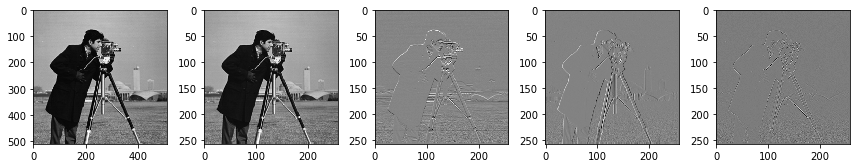

In [148]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data


# Load image
original = pywt.data.camera()
# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([original, LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)



fig.tight_layout()
plt.show()

In [170]:
pywt.wavelist(kind='discrete')

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'haar',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',
 'rbio3.3',
 'rbio3.5',
 'rbio3.7',
 'rbio3.9',
 'rbio4.4',
 'rbio5.5',
 'rbio6.8',
 'sym2',
 'sym3',
 'sym4',
 'sym5',
 'sym6',
 'sym7',
 'sym8',
 'sym9',
 'sym10',
 'sym11',
 'sym12',
 'sym13',

In [98]:
sampling_period = 1/300.
wavelet = "mexh"
scale = np.linspace(2, 20, 19)
f = pywt.scale2frequency(wavelet, scale)/sampling_period
print(f)

[37.5        25.         18.75       15.         12.5        10.71428571
  9.375       8.33333333  7.5         6.81818182  6.25        5.76923077
  5.35714286  5.          4.6875      4.41176471  4.16666667  3.94736842
  3.75      ]
